## 1. Cross validation and grid search for the best parameter set.

Notice: We used package in this model. Also, since the random forest regression model cost very much run time for complex parameters, this cell might cost much longer time than expected to finish if you want to generate all results for the below parameter grid.

If you want to see a quick result to test the code if it is runnable, you can decrease the tested parameters in parameter grid to accelerate this cell's runtime. 

For example, the current cell result was generated using the below grid and this process takes about 7 minutes to generate all results:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 15]
}

In [1]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import numpy as np
import pandas as pd

# read in the data
cleaned = np.loadtxt('outlier_cleaned.csv', delimiter=",")[1:]
pIC50 = pd.read_csv("./CHEMBI_active.csv")['pIC50'].to_numpy()

# Shuffle and split the data into training set and testing set
np.random.seed(13)
indices = np.arange(cleaned.shape[0])
np.random.shuffle(indices)
X = cleaned[indices]
y = pIC50[indices]

split_idx = int(0.8 * len(X))

# Split the indices
train_indices = indices[:split_idx]
val_indices = indices[split_idx:]

# Create the training and testing sets
X_t, X_val = X[train_indices], X[val_indices]
y_t, y_val = y[train_indices], y[val_indices]


# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200, 300, 400, 500],
    'max_depth': [10, 15, 20, 30, None]
}

# Create the random forest regression model
rf = RandomForestRegressor(random_state=42)

# Initialize the GridSearchCV object
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1)

# Fit the grid search to the data
grid_search.fit(X_t, y_t)

# Get the best model
best_rf = grid_search.best_estimator_

# Print the best parameters and the corresponding score
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation MSE:", -grid_search.best_score_)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best parameters: {'max_depth': 15, 'n_estimators': 200}
Best cross-validation MSE: 0.42050986705232285


/var/folders/pg/qkswxmxj16q0rpgkhpzqyy6h0000gn/T/ipykernel_99770/3950815546.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_data['mean_test_score'] = -plot_data['mean_test_score']
/var/folders/pg/qkswxmxj16q0rpgkhpzqyy6h0000gn/T/ipykernel_99770/3950815546.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_data['param_max_depth'] = plot_data['param_max_depth'].astype(str)


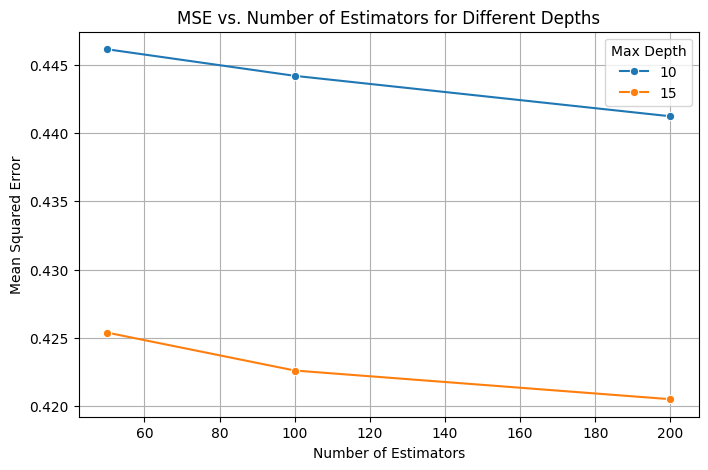

In [2]:
## 2. Diagram the MSE values of all models with different parameters. 
# Here we still use the small size parameter grid for quick result display.
import seaborn as sns
import matplotlib.pyplot as plt

results = pd.DataFrame(grid_search.cv_results_)

plot_data = results.filter(regex='(param_.+|mean_test_score)')
# this is because the MSE computed in the above function is its negative forms.
plot_data['mean_test_score'] = -plot_data['mean_test_score']
plot_data['param_max_depth'] = plot_data['param_max_depth'].astype(str)

# Plotting the change of MSE with n_estimators
plt.figure(figsize=(8,5))
sns.lineplot(data=plot_data, x='param_n_estimators', y='mean_test_score', hue='param_max_depth', marker='o')
plt.title('MSE vs. Number of Estimators for Different Depths')
plt.xlabel('Number of Estimators')
plt.ylabel('Mean Squared Error')
plt.legend(title='Max Depth')
plt.grid(True)
plt.show()

## 2. Using the identified best parameters to do prediction
Still doing a 5-fold cross validation and choose the best trained random forest model to do the final prediction with 300 trees and max depth as 20, which takes about 3.5 minutes.

In [3]:
def MSE(y_true, y_pred):
    return ((y_true - y_pred) ** 2).mean()

def RMSE(y_true, y_pred):
    return np.sqrt(MSE(y_true, y_pred))

def r_squared(y_true, y_pred):
    ss_res = ((y_true - y_pred) ** 2).sum()  # Sum of squares of residuals
    ss_tot = ((y_true - y_true.mean()) ** 2).sum()  # Total sum of squares
    return 1 - (ss_res / ss_tot)

def MAE(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

In [4]:
from sklearn.ensemble import RandomForestRegressor

cleaned = np.loadtxt('outlier_cleaned.csv', delimiter=",")[1:]
pIC50 = pd.read_csv("./CHEMBI_active.csv")['pIC50'].to_numpy()
np.random.seed(13)
cross_folds = 5


#Coordinately shuffle both array 
indices = np.arange(cleaned.shape[0])
np.random.shuffle(indices)
X = cleaned[indices]
y = pIC50[indices]

models_performance = []

split_idx = int(0.8 * len(X))

# Split the indices
train_indices = indices[:split_idx]
val_indices = indices[split_idx:]

# Create the training and validation sets
X_t, X_val = X[train_indices], X[val_indices]
y_t, y_val = y[train_indices], y[val_indices]
num_per_group = len(X_t) // cross_folds

for i in range (cross_folds):
    model_record = {}
    test_start = i * num_per_group
    if i != cross_folds -1:
        test_end= test_start + num_per_group
    else:
        test_end = len(X_t)
    X_test, y_test = X_t[test_start:test_end], y_t[test_start:test_end]
    X_train = np.concatenate([X_t[:test_start], X_t[test_end:]], axis=0)
    y_train = np.concatenate([y_t[:test_start], y_t[test_end:]], axis=0)
    # Building a Random Forest model with specific parameter
    random_forest_model = RandomForestRegressor(n_estimators=300, max_depth= 20, random_state=42)
    random_forest_model.fit(X_train, y_train)
    Y_pred_rf = random_forest_model.predict(X_test)

    squared_differences = (y_test - Y_pred_rf) ** 2
    mse = np.mean(squared_differences)
    model_record["model"] = random_forest_model
    model_record["mse"] = mse
    models_performance.append(model_record)

min_mse = float('inf')  
best_param = None

# Loop through each dictionary in the list
for dct in models_performance:
    print(dct['mse'])
    if dct['mse'] < min_mse:
        min_mse = dct['mse']
        best_param = dct['model']


Validation_pred = best_param.predict(X_val)
squared_differences = (y_val - Validation_pred) ** 2
mse = np.mean(squared_differences) 
print("Final Model mse:", mse)
print("Final Model mse:", RMSE(y_val,Validation_pred))
print("Final Model mse:", r_squared(y_val,Validation_pred))
print("Final Model mse:", MAE(y_val,Validation_pred))

0.4361792233865191
0.42696095941677525
0.35303921073063393
0.3793738995510276
0.5012194562434007
Final Model mse: 0.4008526357933744
Final Model mse: 0.6331292409874736
Final Model mse: 0.5618774424100083
Final Model mse: 0.47681126940131235


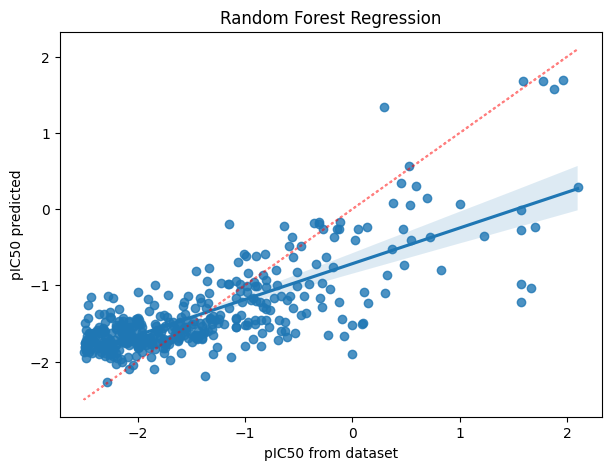

In [5]:
# draw mapping graphs between predicted values and actual values
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(7,5))
sns.regplot(x='Actual', y='Predicted', data=pd.DataFrame({'Actual': y_val, 'Predicted': Validation_pred}))
plt.plot(y_val, y_val, color='red', label='Ideal', alpha = 0.5, linestyle=':')
plt.xlabel('pIC50 from dataset')
plt.ylabel('pIC50 predicted')
plt.title('Random Forest Regression')
plt.show()